In [1]:
import pandas as pd
import xarray as xr
xr.set_options(keep_attrs=True,
               display_expand_data=False)
import yfinance as yf

Download stock prices from Yahoo Finance

In [2]:
data = yf.download('msft aapl goog', period="10y")


[*********************100%%**********************]  3 of 3 completed


In [3]:
data

Adj Close                               Close              \
                  AAPL        GOOG        MSFT        AAPL        GOOG   
Date                                                                     
2013-12-02   17.259239   26.263557   32.377075   19.686787   26.263557   
2013-12-03   17.731718   26.233171   32.259174   20.225714   26.233171   
2013-12-04   17.690380   26.355713   32.789673   20.178572   26.355713   
2013-12-05   17.781183   26.334791   31.998150   20.282143   26.334791   
2013-12-06   17.534454   26.646872   32.301292   20.000713   26.646872   
...                ...         ...         ...         ...         ...   
2023-11-22  191.309998  140.020004  377.850006  191.309998  140.020004   
2023-11-24  189.970001  138.220001  377.429993  189.970001  138.220001   
2023-11-27  189.789993  138.050003  378.609985  189.789993  138.050003   
2023-11-28  190.399994  138.619995  382.700012  190.399994  138.619995   
2023-11-29  189.369995  136.399994  378.850006  189.369995  136.399994   

                              High                                 Low  \
                  MSFT        AAPL        GOOG        MSFT        AAPL   
Date                                                                     
2013-12-02   38.450001   20.154642   26.559200   38.779999   19.672144   
2013-12-03   38.310001   20.227858   26.486721   38.490002   19.917143   
2013-12-04   38.939999   20.328215   26.500172   38.980000   20.029285   
2013-12-05   38.000000   20.540714   26.392574   38.880001   20.228930   
2013-12-06   38.360001   20.241072   26.650108   38.549999   19.984644   
...                ...         ...         ...         ...         ...   
2023-11-22  377.850006  192.929993  141.100006  379.790009  190.830002   
2023-11-24  377.429993  190.899994  139.677002  377.970001  189.250000   
2023-11-27  378.609985  190.669998  139.630005  380.640015  188.899994   
2023-11-28  382.700012  191.080002  138.660004  383.000000  189.399994   
2023-11-29  378.850006  192.089996  139.669998  384.299988  188.970001   

                                          Open                          \
                  GOOG        MSFT        AAPL        GOOG        MSFT   
Date                                                                     
2013-12-02   26.170904   38.060001   19.928572   26.488464   38.090000   
2013-12-03   26.127567   38.080002   19.939285   26.175636   38.139999   
2013-12-04   26.151976   38.119999   20.196428   26.186098   38.209999   
2013-12-05   26.179125   37.180000   20.451786   26.331305   38.849998   
2013-12-06   26.403034   37.990002   20.206785   26.644878   38.419998   
...                ...         ...         ...         ...         ...   
2023-11-22  139.000000  374.970001  191.490005  139.100006  378.000000   
2023-11-24  137.470001  375.140015  190.869995  139.539993  377.329987   
2023-11-27  137.539993  376.200012  189.919998  137.570007  376.779999   
2023-11-28  137.039993  378.160004  189.779999  137.630005  378.350006   
2023-11-29  136.294998  377.440002  190.899994  138.985001  383.760010   

               Volume                       
                 AAPL      GOOG       MSFT  
Date                                        
2013-12-02  472544800  55133884   42950400  
2013-12-03  450968000  67295297   52109800  
2013-12-04  377809600  47842656   51983600  
2013-12-05  447580000  45517975  116305000  
2013-12-06  344352400  57366220   36457300  
...               ...       ...        ...  
2023-11-22   39617700  17306400   23345300  
2023-11-24   24048300   8828600   10176600  
2023-11-27   40552600  17886400   22179200  
2023-11-28   38415400  17046900   20453100  
2023-11-29   42967700  20994400   28942500  

[2516 rows x 18 columns]

Build an xarray Dataset to store prices

In [4]:
ds = data['Adj Close'].stack().rename_axis(['date', 'ticker']).rename('price').to_xarray().to_dataset()
ds

<xarray.Dataset>
Dimensions:  (date: 2516, ticker: 3)
Coordinates:
  * date     (date) datetime64[ns] 2013-12-02 2013-12-03 ... 2023-11-29
  * ticker   (ticker) object 'AAPL' 'GOOG' 'MSFT'
Data variables:
    price    (date, ticker) float64 17.26 26.26 32.38 ... 189.4 136.4 378.9

Calculate returns from prices, store in Dataset

In [5]:
ds['ret'] = ds.price.diff(dim='date') / ds.price
ds

<xarray.Dataset>
Dimensions:  (date: 2516, ticker: 3)
Coordinates:
  * date     (date) datetime64[ns] 2013-12-02 2013-12-03 ... 2023-11-29
  * ticker   (ticker) object 'AAPL' 'GOOG' 'MSFT'
Data variables:
    price    (date, ticker) float64 17.26 26.26 32.38 ... 189.4 136.4 378.9
    ret      (date, ticker) float64 nan nan nan ... -0.005439 -0.01628 -0.01016

Calculate time series of realized volatility, exponentially weighted

In [6]:
def get_volatility_set(ret, halflifes):
    return xr.concat([ds.ret.rolling_exp({'date': h}, window_type='halflife').std() 
                       for h in halflifes],
                       dim=pd.Index(halflifes, name='vol_type'))

In [7]:
halflifes = [21, 63, 126, 252, 512]

ds['vol'] = get_volatility_set(ds.ret, halflifes)
ds

<xarray.Dataset>
Dimensions:   (date: 2516, ticker: 3, vol_type: 5)
Coordinates:
  * date      (date) datetime64[ns] 2013-12-02 2013-12-03 ... 2023-11-29
  * ticker    (ticker) object 'AAPL' 'GOOG' 'MSFT'
  * vol_type  (vol_type) int64 21 63 126 252 512
Data variables:
    price     (date, ticker) float64 17.26 26.26 32.38 ... 189.4 136.4 378.9
    ret       (date, ticker) float64 nan nan nan ... -0.005439 -0.01628 -0.01016
    vol       (vol_type, date, ticker) float64 nan nan nan ... 0.01966 0.01832

Calculate time series of correlation, exponentially weighted

In [8]:
def get_ewm_corr(ret, halflife):
    return (ret.to_pandas()
            .ewm(halflife=halflife)
            .corr()
            .stack()
            .rename_axis(['date', 'ticker', 'ticker_1'])
            .rename('corr')
            .to_xarray())

def get_correlation_set(ret, halflifes):
    return xr.concat([get_ewm_corr(ret, h) for h in halflifes],
                     dim=pd.Index(halflifes, name='corr_type'))

In [9]:
ds['corr'] = get_correlation_set(ds.ret, halflifes)
ds

<xarray.Dataset>
Dimensions:    (date: 2516, ticker: 3, vol_type: 5, ticker_1: 3, corr_type: 5)
Coordinates:
  * date       (date) datetime64[ns] 2013-12-02 2013-12-03 ... 2023-11-29
  * ticker     (ticker) object 'AAPL' 'GOOG' 'MSFT'
  * vol_type   (vol_type) int64 21 63 126 252 512
  * ticker_1   (ticker_1) object 'AAPL' 'GOOG' 'MSFT'
  * corr_type  (corr_type) int64 21 63 126 252 512
Data variables:
    price      (date, ticker) float64 17.26 26.26 32.38 ... 189.4 136.4 378.9
    ret        (date, ticker) float64 nan nan nan ... -0.01628 -0.01016
    vol        (vol_type, date, ticker) float64 nan nan nan ... 0.01966 0.01832
    corr       (corr_type, date, ticker, ticker_1) float64 nan nan ... 1.0

Select a particular correlation matrix

In [10]:
ds.corr.sel(date='2023-11-29', corr_type=63).to_pandas()

ticker_1,AAPL,GOOG,MSFT
ticker,,,
AAPL,1.000000,0.562591,0.612568
GOOG,0.562591,1.000000,0.477951
MSFT,0.612568,0.477951,1.000000


Look at the correlation of a stock pair over time

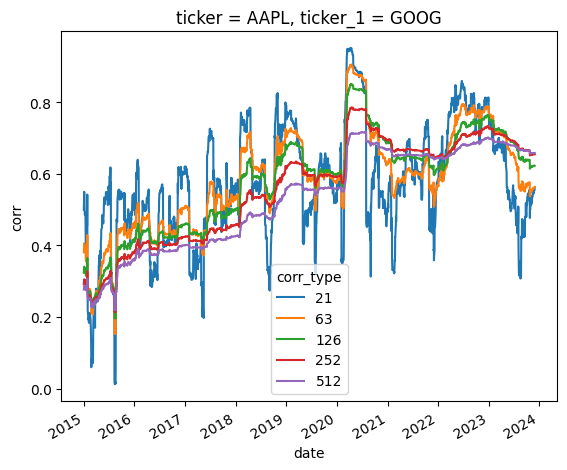

In [12]:
ds.corr.sel(ticker='AAPL', ticker_1='GOOG', date=slice('2015', None)).plot(x='date', hue='corr_type')